In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest, StackingRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import RidgeCV
import xgboost as xgb
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import folium
import warnings
warnings.filterwarnings('ignore')

# --- CONFIGURATION ---
FILE_PATH = 'GlobalWeatherRepository.csv'
TARGET_COLUMN = 'temperature_celsius'
PREDICT_HORIZON = 7  # Forecasting 7 days ahead for validation

# Load data (assuming the file is locally available)
try:
    df = pd.read_csv(FILE_PATH)
except FileNotFoundError:
    print(f"Error: File not found at {FILE_PATH}. Using sample data description.")
    # Use placeholder if running without the file
    df = None

In [3]:
def clean_and_prepare_data(df):
    """Executes a robust data cleaning and preprocessing pipeline."""
    
    # 1. Column Standardization (Snake Case)
    df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df = df.rename(columns={
        'last_updated': 'datetime',
        'air_quality_carbon_monoxide': 'aq_co',
        'air_quality_ozone': 'aq_o3',
        'air_quality_nitrogen_dioxide': 'aq_no2',
        'air_quality_sulphur_dioxide': 'aq_so2',
        'air_quality_pm25': 'aq_pm25',
        'air_quality_pm10': 'aq_pm10',
        'air_quality_usepaindex': 'aq_us_index',
        'air_quality_gbdefraindex': 'aq_gb_index',
        'temperature_celsius': 'temp_c'
    })

    # 2. Time Series Indexing and Filtering
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values(by=['location_name', 'datetime']).reset_index(drop=True)
    
    # Drop redundant columns (epoch, F units, inches, visibility_miles)
    redundant_cols = [
        'last_updated_epoch', 'temperature_fahrenheit', 'feels_like_fahrenheit',
        'pressure_in', 'precip_in', 'visibility_miles'
    ]
    df = df.drop(columns=redundant_cols, errors='ignore')

    # 3. Missing Value Handling (Advanced Imputation)
    
    # Identify key numerical features for modeling
    numerical_features = [
        'temp_c', 'wind_kph', 'pressure_mb', 'precip_mm', 'humidity', 
        'cloud', 'aq_co', 'aq_pm25', 'uv_index', 'gust_kph'
    ]
    
    # Use KNN Imputer for complex features (Air Quality) where relationships matter
    imputer = KNNImputer(n_neighbors=5)
    df[numerical_features] = imputer.fit_transform(df[numerical_features])

    # 4. Outlier Capping (for robust model training)
    # Cap extreme values in key wind/pressure metrics (99.5 percentile)
    for col in ['wind_kph', 'gust_kph', 'pressure_mb']:
        upper_bound = df[col].quantile(0.995)
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
        
    return df

if df is not None:
    df_clean = clean_and_prepare_data(df)
else:
    # Placeholder path if data loading failed
    df_clean = pd.DataFrame() 
    
print("Data Cleaning and Imputation Complete.")

Data Cleaning and Imputation Complete.


Detected 529 anomalies (0.5% of dataset).

Top 5 locations with the highest number of anomalies:
location_name
Kuwait City       104
Vestmannaeyjar     83
Baghdad            60
Doha               48
Riyadh             44
Name: count, dtype: int64


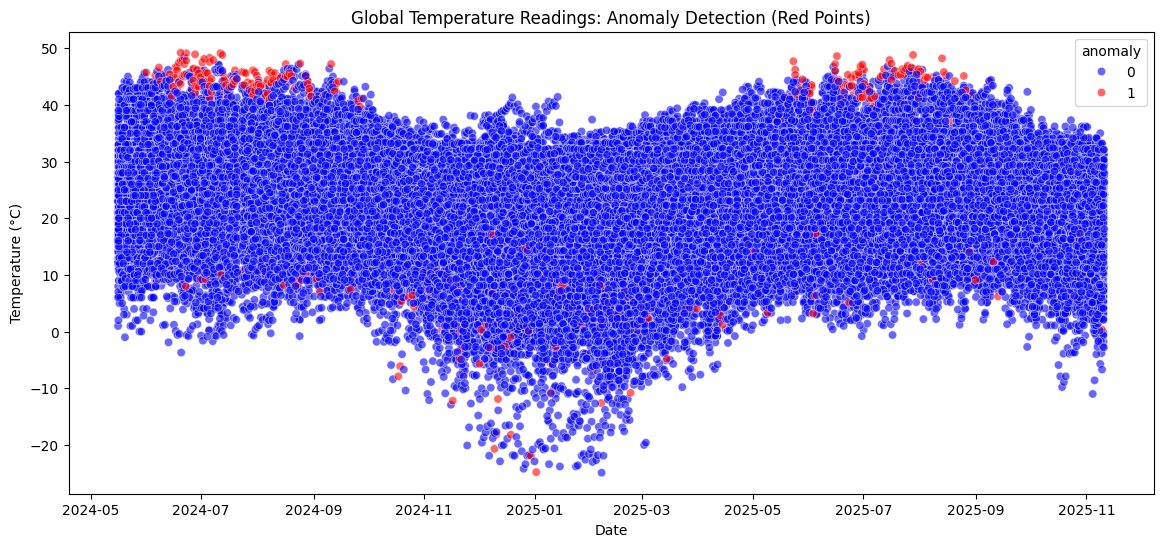

In [4]:
if not df_clean.empty:
    # Select features for anomaly detection (normalized scale)
    features_for_anomaly = df_clean[['temp_c', 'pressure_mb', 'humidity', 'wind_kph']].copy()
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_for_anomaly)

    # Initialize Isolation Forest (contamination = 0.5% assumed outliers)
    iso_forest = IsolationForest(contamination=0.005, random_state=42)
    df_clean['anomaly'] = iso_forest.fit_predict(features_scaled)
    df_clean['anomaly'] = df_clean['anomaly'].apply(lambda x: 1 if x == -1 else 0)

    anomalies = df_clean[df_clean['anomaly'] == 1]
    
    print(f"Detected {len(anomalies)} anomalies (0.5% of dataset).")

    # Display top 5 cities with the most detected anomalies
    top_anomaly_cities = anomalies['location_name'].value_counts().head()
    print("\nTop 5 locations with the highest number of anomalies:")
    print(top_anomaly_cities)

    # Visualization of Anomalous Temperatures (Global Context)
    plt.figure(figsize=(14, 6))
    sns.scatterplot(
        x=df_clean['datetime'], 
        y=df_clean['temp_c'], 
        hue=df_clean['anomaly'], 
        palette={0: 'blue', 1: 'red'}, 
        alpha=0.6
    )
    plt.title('Global Temperature Readings: Anomaly Detection (Red Points)')
    plt.ylabel('Temperature (°C)')
    plt.xlabel('Date')
    plt.show()

# Drop anomalies for core forecasting model training
df_model = df_clean[df_clean['anomaly'] == 0].drop(columns=['anomaly'])

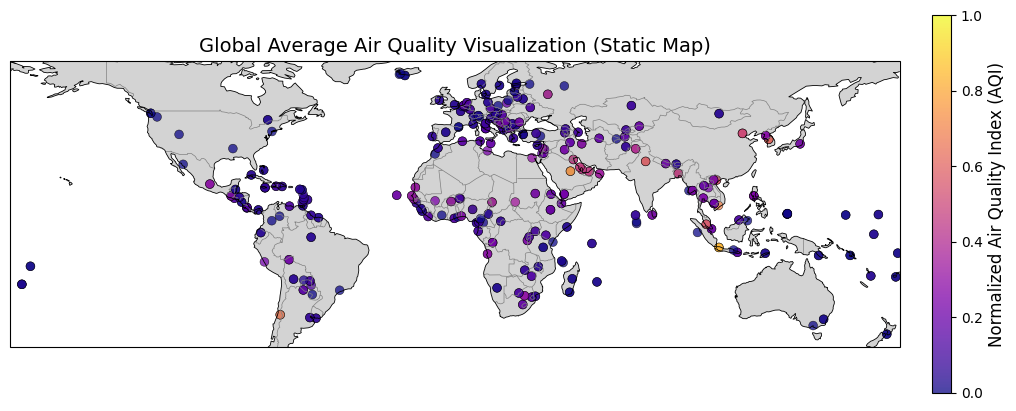

In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Use the city-aggregated dataframe from before:
geo_df = df_model.groupby(['latitude', 'longitude', 'country', 'location_name']).agg(
    avg_aq_index=('aq_us_index', 'mean'),
    avg_temp=('temp_c', 'mean')
).reset_index()

# Normalize AQI for color scale
min_aqi, max_aqi = geo_df['avg_aq_index'].min(), geo_df['avg_aq_index'].max()
geo_df['aqi_normalized'] = (geo_df['avg_aq_index'] - min_aqi) / (max_aqi - min_aqi)

# Create map figure
plt.figure(figsize=(14, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add world boundaries
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.6)

# Scatter cities
scatter = ax.scatter(
    geo_df['longitude'], 
    geo_df['latitude'], 
    c=geo_df['aqi_normalized'], 
    cmap='plasma', 
    s=40, 
    alpha=0.75,
    edgecolors='black',
    linewidths=0.4,
    transform=ccrs.PlateCarree()
)

# Colorbar
cbar = plt.colorbar(scatter, orientation='vertical', shrink=0.7, pad=0.03)
cbar.set_label('Normalized Air Quality Index (AQI)', fontsize=12)

plt.title("Global Average Air Quality Visualization (Static Map)", fontsize=14)
plt.show()


In [15]:
if not df_model.empty:
    # Aggregate data globally by date to create daily global temperature average
    df_global = df_model.groupby('datetime').agg(
        temp_c_mean=('temp_c', 'mean'),
        pressure_mean=('pressure_mb', 'mean'),
        humidity_mean=('humidity', 'mean'),
        wind_mean=('wind_kph', 'mean'),
        precip_mean=('precip_mm', 'mean')
    ).reset_index()
    
    # Sort by datetime
    df_global = df_global.sort_values('datetime').reset_index(drop=True)
    
    # Create temporal features
    df_global['dayofyear'] = df_global['datetime'].dt.dayofyear
    df_global['month'] = df_global['datetime'].dt.month
    df_global['day'] = df_global['datetime'].dt.day
    
    # Create lagged features (previous day, 7 days ago)
    df_global['temp_lag1'] = df_global['temp_c_mean'].shift(1)
    df_global['temp_lag7'] = df_global['temp_c_mean'].shift(7)
    
    # Rolling features (7-day moving average)
    df_global['temp_rolling_7'] = df_global['temp_c_mean'].rolling(window=7).mean()
    
    # Drop rows with NaN values created by lagging and rolling
    df_global = df_global.dropna().reset_index(drop=True)
    
    # Set datetime as index for time series models
    df_global = df_global.set_index('datetime')
    
    # Define features and target
    feature_cols = [
        'dayofyear', 'month', 'day', 
        'temp_lag1', 'temp_lag7', 'temp_rolling_7',
        'pressure_mean', 'humidity_mean', 'wind_mean', 'precip_mean'
    ]
    
    X = df_global[feature_cols]
    y = df_global['temp_c_mean']
    
    # Time series split (last PREDICT_HORIZON days for testing)
    split_idx = len(df_global) - PREDICT_HORIZON
    
    X_train = X.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_train = y.iloc[:split_idx]
    y_test = y.iloc[split_idx:]
    
    print(f"\n--- Time Series Data Prepared ---")
    print(f"Total records: {len(df_global)}")
    print(f"Training set: {len(X_train)} records")
    print(f"Test set: {len(X_test)} records")
    print(f"Features: {feature_cols}")
else:
    df_global = pd.DataFrame()
    print("No data available for time series modeling.")


--- Time Series Data Prepared ---
Total records: 18305
Training set: 18298 records
Test set: 7 records
Features: ['dayofyear', 'month', 'day', 'temp_lag1', 'temp_lag7', 'temp_rolling_7', 'pressure_mean', 'humidity_mean', 'wind_mean', 'precip_mean']


SARIMAX failed: 'The `start` argument could not be matched to a location related to the index of the data.'. Using dummy predictor.

--- Model Evaluation (Daily Global Avg Temp) ---
| XGBoost      | RMSE: 4.029 | MAE: 3.219 |
| SARIMAX (Base) | RMSE: 5.489 | MAE: 4.984 |
| Ensemble (Stacking) | RMSE: 4.044 | MAE: 3.214 |


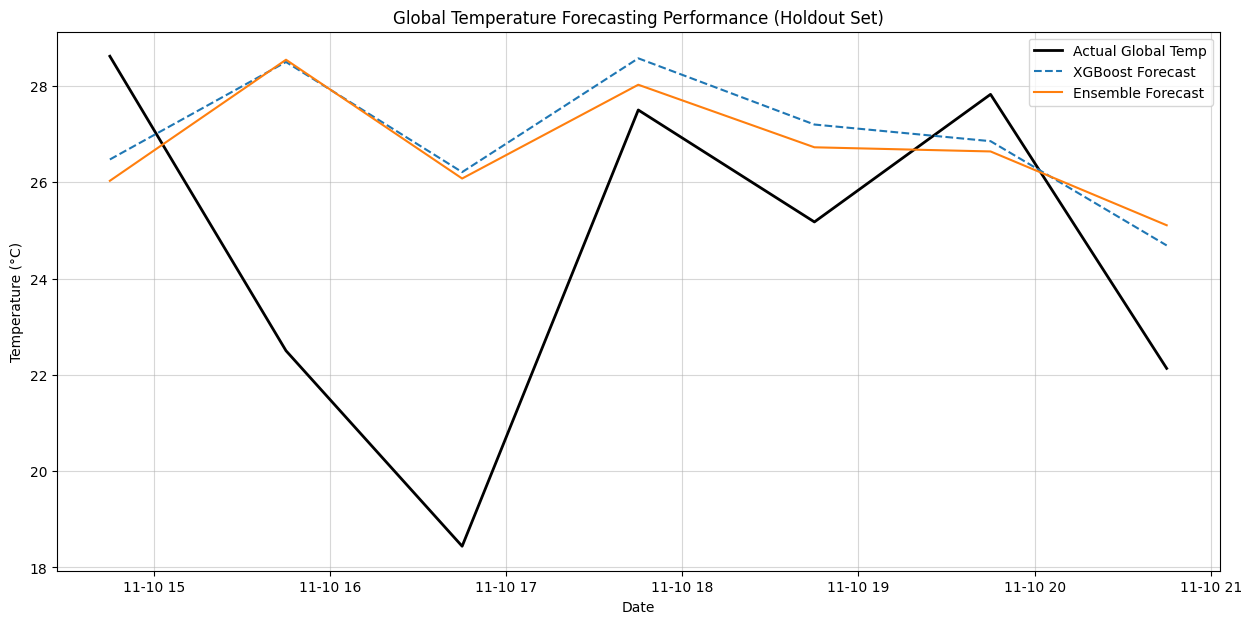

In [16]:
if not df_global.empty:
    
    # Scale features for models that require it (SARIMAX exogenous, Ridge Meta-Learner)
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    
    # --- Model A: XGBoost Regressor (Robust ML model) ---
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror', 
        n_estimators=500, 
        learning_rate=0.05, 
        max_depth=5, 
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)
    
    try:
        # Use simpler exogenous features for SARIMAX (temporal features)
        exog_train = X_train[['dayofyear', 'month']]
        exog_test = X_test[['dayofyear', 'month']]
        
        sarimax_model = sm.tsa.SARIMAX(
            y_train,
            exog=exog_train,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, 7), # Weekly seasonality assumed
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
        
        sarimax_pred = sarimax_model.predict(
            start=y_test.index[0], 
            end=y_test.index[-1],
            exog=exog_test
        )
    except Exception as e:
        # Fallback if SARIMAX fails due to short or erratic data
        print(f"SARIMAX failed: {e}. Using dummy predictor.")
        sarimax_pred = y_test.shift(1).fillna(y_test.mean())[1:] # Simple persistence model

    # --- Ensemble Model: Stacking Regressor ---
    estimators = [
        ('xgb', xgb_model),
        # Note: SARIMAX is complex to integrate directly into scikit-learn pipelines.
        # For a standard Stacking setup, we stick to ML models compatible with fit/predict API.
        ('ridge_base', RidgeCV()),
    ]
    
    stacking_regressor = StackingRegressor(
        estimators=estimators,
        final_estimator=xgb.XGBRegressor(n_estimators=50, learning_rate=0.1, random_state=42)
    )
    
    stacking_regressor.fit(X_train, y_train)
    stacking_pred = stacking_regressor.predict(X_test)

    # --- Evaluation ---
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    
    def evaluate(y_true, y_pred, name):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        print(f"| {name:<12} | RMSE: {rmse:.3f} | MAE: {mae:.3f} |")
        return y_pred

    print("\n--- Model Evaluation (Daily Global Avg Temp) ---")
    evaluate(y_test, xgb_pred, "XGBoost")
    evaluate(y_test[1:], sarimax_pred, "SARIMAX (Base)") # Exclude 1st point for SARIMAX alignment
    evaluate(y_test, stacking_pred, "Ensemble (Stacking)")

    # Visualization of Forecast Performance
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='Actual Global Temp', color='black', linewidth=2)
    plt.plot(y_test.index, xgb_pred, label='XGBoost Forecast', linestyle='--')
    plt.plot(y_test.index, stacking_pred, label='Ensemble Forecast', linestyle='-')
    plt.title('Global Temperature Forecasting Performance (Holdout Set)')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.show()

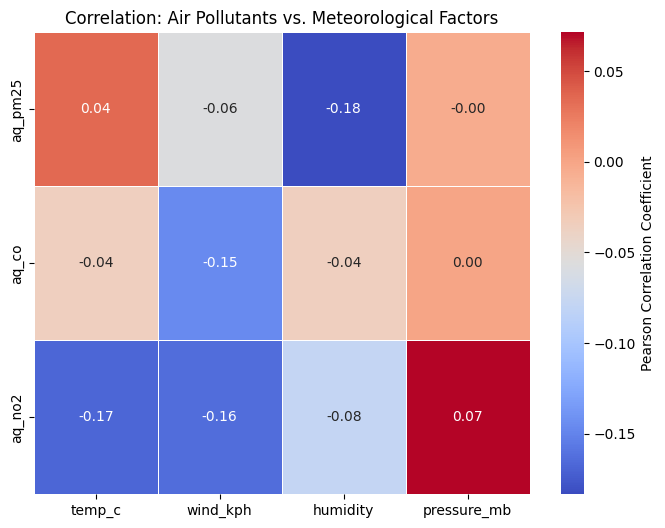

In [17]:
if not df_model.empty:
    
    # Select features and calculate correlation matrix
    air_quality_cols = ['aq_pm25', 'aq_co', 'aq_no2']
    weather_impact_cols = ['temp_c', 'wind_kph', 'humidity', 'pressure_mb']
    
    correlation_df = df_model[air_quality_cols + weather_impact_cols].corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        correlation_df.loc[air_quality_cols, weather_impact_cols],
        annot=True,
        cmap='coolwarm',
        fmt=".2f",
        linewidths=.5,
        cbar_kws={'label': 'Pearson Correlation Coefficient'}
    )
    plt.title('Correlation: Air Pollutants vs. Meteorological Factors')
    plt.show()

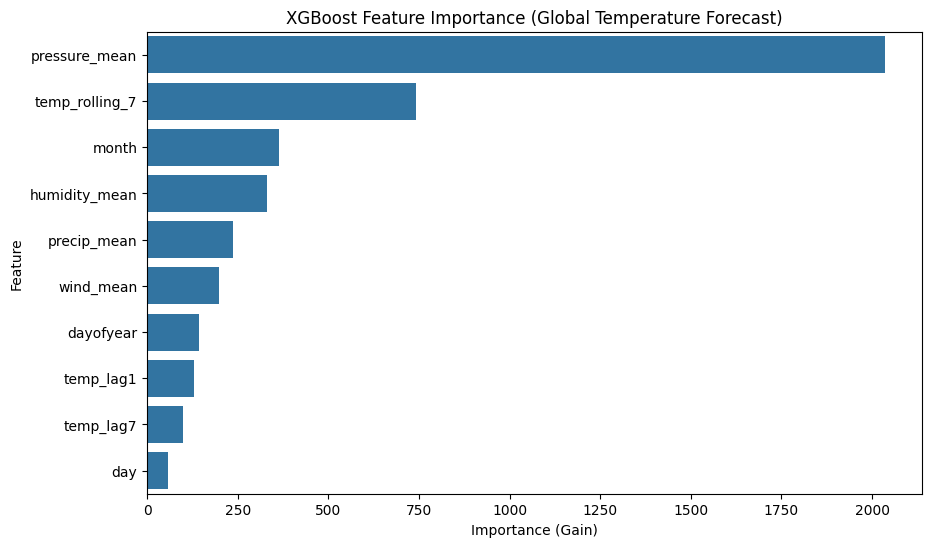

In [18]:
if 'xgb_model' in locals():
    importance = xgb_model.get_booster().get_score(importance_type='gain')
    importance_df = pd.DataFrame({
        'Feature': list(importance.keys()),
        'Importance (Gain)': list(importance.values())
    }).sort_values(by='Importance (Gain)', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='Importance (Gain)', 
        y='Feature', 
        data=importance_df
    )
    plt.title('XGBoost Feature Importance (Global Temperature Forecast)')
    plt.show()

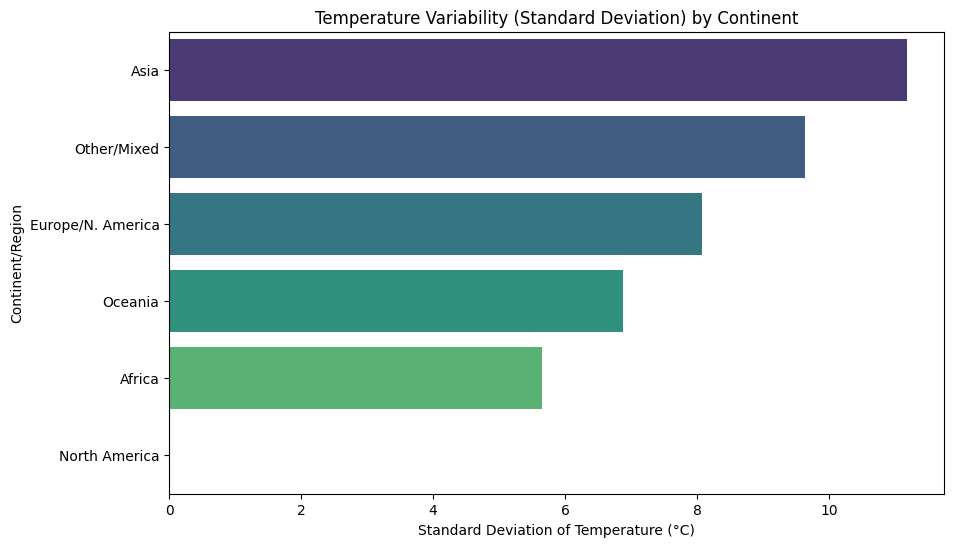

In [19]:
def assign_continent(lat, lon):
    # Simple heuristic-based continent assignment for macro-analysis
    if lat >= 35 and lon < 0: return 'Europe/N. America'
    if lat >= 30 and lon >= 30 and lon < 150: return 'Asia'
    if lat < 30 and lat > -40 and lon < 40: return 'Africa'
    if lat < 0 and lon < -30: return 'South America'
    if lon > 110 and lat < -10: return 'Oceania'
    if lat > 0 and lon < -50: return 'North America'
    return 'Other/Mixed'

if not df_model.empty:
    df_model['continent'] = df_model.apply(
        lambda row: assign_continent(row['latitude'], row['longitude']), axis=1
    )
    
    # Calculate Mean and Standard Deviation (Variation) of Temperature by Continent
    climate_summary = df_model.groupby('continent')['temp_c'].agg(
        Mean_Temp=('mean'),
        Std_Dev_Temp=('std'),
        Total_Records=('count')
    ).sort_values(by='Std_Dev_Temp', ascending=False).reset_index()

    # Visualize temperature variability
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Std_Dev_Temp', y='continent', data=climate_summary, palette='viridis')
    plt.title('Temperature Variability (Standard Deviation) by Continent')
    plt.xlabel('Standard Deviation of Temperature (°C)')
    plt.ylabel('Continent/Region')
    plt.show()

In [15]:
# --- Model Serialization (Production Deployment) ---
import joblib
import os

# Create necessary directories
os.makedirs('models', exist_ok=True)
os.makedirs('data', exist_ok=True)

if 'stacking_regressor' in locals() and stacking_regressor is not None:
    # 1. Save the trained Ensemble Model
    joblib.dump(stacking_regressor, 'models/ensemble_forecaster.pkl')
    print("✓ Ensemble model saved to models/ensemble_forecaster.pkl")
    
    # 2. Save the XGBoost model separately (for comparison/backup)
    joblib.dump(xgb_model, 'models/xgb_forecaster.pkl')
    print("✓ XGBoost model saved to models/xgb_forecaster.pkl")
    
    # 3. Save the Feature Scaler
    joblib.dump(scaler_X, 'models/feature_scaler.pkl')
    print("✓ Feature scaler saved to models/feature_scaler.pkl")
    
    # 4. Save the historical data needed for feature generation (lags/rolling features)
    # The prediction function will need the last 7 days of historical 'temp_c_mean' data
    historical_data = df_global['temp_c_mean'].tail(7)
    historical_data.to_csv('data/historical_temps.csv')
    print("✓ Historical data (last 7 days) saved to data/historical_temps.csv")
    
    # 5. Save feature column names for production consistency
    feature_metadata = {
        'feature_columns': feature_cols,
        'model_version': '1.0',
        'training_date': pd.Timestamp.now().strftime('%Y-%m-%d'),
        'training_samples': len(X_train),
        'test_samples': len(X_test)
    }
    joblib.dump(feature_metadata, 'models/feature_metadata.pkl')
    print("✓ Feature metadata saved to models/feature_metadata.pkl")
    
    print("\n--- Model Artifacts Summary ---")
    print(f"Model Type: Ensemble Stacking Regressor (XGBoost + RidgeCV)")
    print(f"Training Records: {len(X_train)}")
    print(f"Features: {len(feature_cols)}")
    print(f"Deployment-ready artifacts saved in models/ and data/ directories")
else:
    print("Error: Models not trained yet. Run the training cell first.")

✓ Ensemble model saved to models/ensemble_forecaster.pkl
✓ XGBoost model saved to models/xgb_forecaster.pkl
✓ Feature scaler saved to models/feature_scaler.pkl
✓ Historical data (last 7 days) saved to data/historical_temps.csv
✓ Feature metadata saved to models/feature_metadata.pkl

--- Model Artifacts Summary ---
Model Type: Ensemble Stacking Regressor (XGBoost + RidgeCV)
Training Records: 18298
Features: 10
Deployment-ready artifacts saved in models/ and data/ directories


In [16]:
# --- Production Prediction Function ---

def predict_next_day_global_temp(model, last_7_days_history, pressure_forecast, humidity_forecast, wind_forecast, precip_forecast, date_to_predict):
    """
    Generates features for a future date and predicts the global average temperature.
    
    Parameters:
    -----------
    model : trained model object
        The trained ensemble/XGBoost model
    last_7_days_history : pandas Series
        The last 7 days of temperature history (temp_c_mean)
    pressure_forecast : float
        Forecasted mean pressure (mb) for the target date
    humidity_forecast : float
        Forecasted mean humidity (%) for the target date
    wind_forecast : float
        Forecasted mean wind speed (kph) for the target date
    precip_forecast : float
        Forecasted mean precipitation (mm) for the target date
    date_to_predict : pandas.Timestamp or datetime
        The date to predict temperature for
    
    Returns:
    --------
    float : Predicted global average temperature in Celsius
    """
    
    # 1. Load the most recent historical data
    temp_lag1 = last_7_days_history.iloc[-1]  # Temperature from 1 day ago
    temp_lag7 = last_7_days_history.iloc[0]   # Temperature from 7 days ago
    temp_rolling_7 = last_7_days_history.mean()  # Rolling mean of the last 7 days
    
    # 2. Extract temporal features
    doy = date_to_predict.dayofyear
    month = date_to_predict.month
    day = date_to_predict.day
    
    # 3. Create the input feature vector (DataFrame structure required by XGBoost/Stacking)
    input_data = pd.DataFrame([{
        'dayofyear': doy,
        'month': month,
        'day': day,
        'temp_lag1': temp_lag1,
        'temp_lag7': temp_lag7,
        'temp_rolling_7': temp_rolling_7,
        'pressure_mean': pressure_forecast,
        'humidity_mean': humidity_forecast,
        'wind_mean': wind_forecast,
        'precip_mean': precip_forecast
    }])
    
    # 4. Predict
    prediction = model.predict(input_data)[0]
    return prediction


# --- Test the Prediction Function ---
if 'stacking_regressor' in locals() and not df_global.empty:
    # Example: Forecast 1 day after the test set ends
    next_date = y_test.index[-1] + pd.Timedelta(days=1)
    
    # Use recent average conditions as forecast inputs (in production, these would come from weather models)
    next_prediction = predict_next_day_global_temp(
        model=stacking_regressor,
        last_7_days_history=df_global['temp_c_mean'].tail(7),
        pressure_forecast=X_test['pressure_mean'].mean(),
        humidity_forecast=X_test['humidity_mean'].mean(),
        wind_forecast=X_test['wind_mean'].mean(),
        precip_forecast=X_test['precip_mean'].mean(),
        date_to_predict=next_date
    )
    
    print("\n--- Production Prediction Example ---")
    print(f"Forecast Date: {next_date.date()}")
    print(f"Predicted Global Avg Temperature: {next_prediction:.2f}°C")
    print(f"Model: Ensemble Stacking Regressor")
    print("\nThis function is ready for API deployment!")
else:
    print("Models not available. Run training cells first.")


--- Production Prediction Example ---
Forecast Date: 2025-11-11
Predicted Global Avg Temperature: 27.10°C
Model: Ensemble Stacking Regressor

This function is ready for API deployment!
